In [2]:

from astroquery.gaia import Gaia
from astropy.table import Table
import numpy as np
import re

# get the vertex polygons from the previous step

filename = 'gd1_data_05.hdf5'
radec_vertices = Table.read(filename, path="radec_vertices")
pm_vertices = Table.read(filename, path="pm_vertices")

#", ".join(pm_vertices.as_array())


In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

# create a query to get the Gaia data

def table_to_string(table):
    s = np.array2string(table.as_array(), max_line_width=1000, separator=', ')
    s = re.sub('[\\[\\]()]', '', s)
    return s


column_list = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.number_of_neighbours',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
               'ps.i_mean_psf_mag']

columns = ", ".join(column_list)


#    JOIN gaiadr3.panstarrs1_best_neighbour as best
#        USING(source_id)
#    JOIN gaiadr3.panstarrs1_original_valid as ps
#        ON best.original_ext_source_id = ps.obj_id

query_base = """SELECT
    {columns}
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id

    WHERE gaia.parallax < 1
        AND gaia.bp_rp BETWEEN -0.75 AND 2
        AND 1 = CONTAINS(
            POINT(gaia.ra,gaia.dec),
            POLYGON({radec_vertices})
        )
        AND 1 = CONTAINS(
            POINT(gaia.pmra,gaia.pmdec),
            POLYGON( {pm_vertices} )
        )
"""

query = query_base.format(columns=columns, radec_vertices=table_to_string(radec_vertices), pm_vertices=table_to_string(pm_vertices))
print(query)

SELECT
    gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.number_of_neighbours, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id

    WHERE gaia.parallax < 1
        AND gaia.bp_rp BETWEEN -0.75 AND 2
        AND 1 = CONTAINS(
            POINT(gaia.ra,gaia.dec),
            POLYGON(135.30559859,  8.39862394, 126.50951509, 13.44494196, 163.01736558, 54.24242734, 172.93285363, 46.47260492, 135.30559859,  8.39862394)
        )
        AND 1 = CONTAINS(
            POINT(gaia.pmra,gaia.pmdec),
            POLYGON( 356.76942623, -14.55754102, 357.54049051, -13.63622195, 357.38827797, -13.24797471, 357.26528599, -13.09054471, 356.80076854, -12.5942653 , 356.65917454, -12.47611926, 355.42572056, -11.6842453 , 354.04840728, -11.10547884, 35

In [4]:

job = Gaia.launch_job_async(query=query)
table = job.get_results()

table



INFO: Query finished. [astroquery.utils.tap.core]


source_id,ra,dec,pmra,pmdec,number_of_neighbours,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
585376176697179648,135.49622038026945,8.964182850802915,-6.119692172421267,-12.424917916534126,1,0,17.701000213623,17.1168003082275
585386450259576832,135.08322914433705,9.031119615938406,-4.523717518745434,-12.660191877360843,1,0,19.6191005706787,17.6896991729736
585418993226027264,134.52043395680994,9.020806814953659,-4.891025932464174,-12.360692639292942,1,0,16.0396003723145,15.6280002593994
585426067037572352,134.6539460081194,9.121023184196194,-4.841303229915545,-13.360642839008744,1,0,19.7301998138428,18.7395000457764
585459602143647488,135.00924658733018,9.34102690928007,-5.937011840248246,-11.316556084048825,1,0,--,19.039400100708
686366942479608192,134.77686008396304,23.063991605626548,-6.312872046809079,-11.433005411675353,1,0,19.6375007629395,19.0701999664307
686370614676090240,135.0754962250779,23.13908484336188,-4.87089329507524,-12.184988427721807,1,0,21.7432994842529,19.4193992614746
686382713599649664,135.55250131385645,22.851207859862598,-6.513159423851131,-11.861131865629002,1,0,21.7695007324219,19.8374004364014


In [5]:
table.to_pandas().describe()

,source_id,ra,dec,pmra,pmdec,number_of_neighbours,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
count,8.053000e+03,8053.000000,8053.000000,8053.000000,8053.000000,8053.0,8053.000000,7942.000000,8050.000000
mean,7.347651e+17,147.340764,32.600784,-4.919946,-12.789870,1.0,0.000373,19.208838,18.234117
std,7.621701e+16,10.235277,10.913172,1.117429,0.823941,0.0,0.019299,1.905187,1.619795
min,5.853762e+17,126.730314,8.964183,-7.290959,-14.743672,1.0,0.000000,12.130100,10.329900
25%,6.610312e+17,139.264075,23.999484,-5.830555,-13.407530,1.0,0.000000,17.976926,17.229625
50%,7.527718e+17,146.415539,33.200689,-4.960483,-12.765915,1.0,0.000000,19.495150,18.576650
75%,8.021454e+17,154.965679,41.620938,-4.049447,-12.149723,1.0,0.000000,20.678375,19.569524
max,8.496230e+17,172.583468,54.081410,-2.489919,-11.114415,1.0,1.000000,27.381001,21.497900


In [ ]:
# convert to GS1 coordinates
from gala.coordinates import GD1Koposov10
from gala.coordinates import reflex_correct

skycoord = SkyCoord(
            ra=table['ra'], 
            dec=table['dec'],
            pm_ra_cosdec=table['pmra'],
            pm_dec=table['pmdec'], 
            distance=8*u.kpc, 
            radial_velocity=0*u.km/u.s)

gd1_frame = GD1Koposov10()
transformed = skycoord.transform_to(gd1_frame)
skycoord_gd1 = reflex_correct(transformed)

transformed_tbl = table.copy()
transformed_tbl['phi1'] = skycoord_gd1.phi1
transformed_tbl['phi2'] = skycoord_gd1.phi2
transformed_tbl['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
transformed_tbl['pm_phi2'] = skycoord_gd1.phi2

        phi1       
        deg        
-------------------
 -69.41626724603123
  -69.5702704110472
 -69.86637877328758
 -69.71220677574962
 -69.34188972763752
-57.715721764291004
-57.508936529875314
 -57.52642453991217
-57.289413651497455
                ...
 -61.85039204206265
  -61.9110445192286
 -61.91560528857019
 -61.68706214481227
-61.652453749063056
-62.370257874133415
 -62.01240210186501
-61.786914495128826
 -61.61216983506131
 -68.33888738535484
Length = 8053 rows         phi2       
        deg        
-------------------
 -4.869069504019349
-4.4852579887371045
 -4.014247386824419
 -4.075688310212257
 -4.262722256232078
  3.044824727304425
  2.848748713725321
 2.3239848648961545
  2.064058422313843
                ...
 -3.332687660009725
 -3.264830163115579
 -3.222805515664372
-3.2467443380701906
-3.0722463895066427
-2.7466130750218394
-2.5155113012172112
 -2.764816776855001
 -2.950904960967643
-0.5266574095628722
Length = 8053 rows


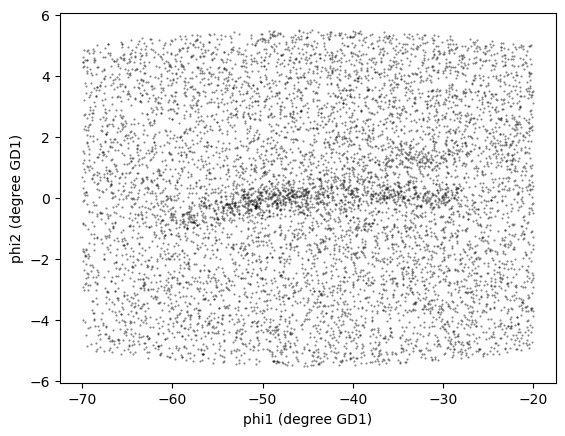

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# replot

x = transformed_tbl['phi1']
y = transformed_tbl['phi2']

plt.plot(x, y, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');

print(x,y)

In [ ]:
# save table to disk

filename = 'gd1_data_05b.hdf5'
transformed_tbl.write(filename, path="transformed", serialize_meta=True, overwrite=True)

from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB


0.733515739440918